I wanted to make a Time Series Forecast Analysis of Take-Two Interactive Software, Inc. (TTWO) for the last 9 years (from 1/1/2010 to 1/1/2020) Data taken from https://finance.yahoo.com/

In [1]:
from datetime import datetime
import pandas as pd
from pandas.plotting import lag_plot
import numpy as np


# Plotting imports
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


# Setting default figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10


# Forecasting Imports
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR,ARResults
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from pmdarima.arima import auto_arima


# Math/Error metrics imports
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from math import sqrt

In [2]:
# Loading CSV file with index as date
df = pd.read_csv('finance.yahoo.com-TTWO.csv',index_col='Date',parse_dates= True)
# Dropping columns not needed
TTWO = df.drop(columns= ['Open','High','Low','Close','Volume'])
valid = pd.read_csv('finance.yahoo.com-TTWO-validation.csv',index_col='Date',parse_dates= True).drop(columns= ['Open','High','Low','Close','Volume'])

In [3]:
# Displaying dataframe
TTWO.info()
TTWO

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2010-01-04 to 2019-12-31
Data columns (total 1 columns):
Adj Close    2516 non-null float64
dtypes: float64(1)
memory usage: 39.3 KB


,Adj Close
Date,
2010-01-04,10.400000
2010-01-05,10.470000
2010-01-06,10.440000
2010-01-07,10.390000
2010-01-08,10.420000
...,...
2019-12-24,123.930000
2019-12-26,123.989998
2019-12-27,124.470001


In [4]:
# Checking if the datetime is index values
TTWO.index

DatetimeIndex(['2010-01-04', '2010-01-05', '2010-01-06', '2010-01-07',
               '2010-01-08', '2010-01-11', '2010-01-12', '2010-01-13',
               '2010-01-14', '2010-01-15',
               ...
               '2019-12-17', '2019-12-18', '2019-12-19', '2019-12-20',
               '2019-12-23', '2019-12-24', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='Date', length=2516, freq=None)

In [5]:
# Aaggregating the data by month (averaging the values by month)
TTWO_weekly =TTWO.resample('W').mean()
# Displaying dataframe
TTWO_weekly

,Adj Close
Date,
2010-01-10,10.424000
2010-01-17,10.292000
2010-01-24,9.585000
2010-01-31,9.242000
2010-02-07,9.364000
...,...
2019-12-08,122.700001
2019-12-15,122.368000
2019-12-22,122.634000


In [6]:
# Aaggregating the data by month (averaging the values by month)
TTWO_monthly =TTWO.resample('MS').mean()
# Displaying dataframe
TTWO_monthly

valid_monthly = valid.resample('MS').mean()

In [7]:
# Aaggregating the data by month (averaging the values by month)
TTWO_annually =TTWO.resample('Y').mean()
# Displaying dataframe
TTWO_annually

,Adj Close
Date,
2010-12-31,10.282659
2011-12-31,14.374405
2012-12-31,12.280920
2013-12-31,16.176190
2014-12-31,22.067897
2015-12-31,29.267302
2016-12-31,40.248532
2017-12-31,80.860159
2018-12-31,115.897530


In [8]:
yearly = TTWO_monthly.groupby(pd.Grouper(freq ='A'))
yearly.describe()
# yearly.head()

Adj Close                                                \
               count        mean        std        min         25%   
Date                                                                 
2010-12-31      12.0   10.275100   0.843548   9.000455    9.810833   
2011-12-31      12.0   14.386680   1.308214  11.916087   13.640714   
2012-12-31      12.0   12.308719   2.384168   9.181905   10.558716   
2013-12-31      12.0   16.155247   1.660358  12.361429   15.492977   
2014-12-31      12.0   22.053001   2.873569  17.893809   20.500357   
2015-12-31      12.0   29.245201   3.316590  24.873809   27.362658   
2016-12-31      12.0   40.185929   5.373694  33.342105   36.077630   
2017-12-31      12.0   80.625733  22.300738  51.733000   59.634136   
2018-12-31      12.0  115.752131  10.267440  98.018095  110.683497   
2019-12-31      12.0  111.607943  13.554261  92.666667  101.390910   

                                                
                   50%         75%         max  
Date                                            
2010-12-31   10.112016   10.692929   12.190909  
2011-12-31   14.477083   15.351076   16.277143  
2012-12-31   11.915988   14.665750   15.750455  
2013-12-31   16.149545   17.365098   18.424545  
2014-12-31   21.572143   22.909865   27.820000  
2015-12-31   28.993191   30.462500   35.638636  
2016-12-31   38.961955   44.600119   49.323809  
2017-12-31   76.012318  101.040568  114.777143  
2018-12-31  115.102857  123.900435  133.108422  
2019-12-31  114.602931  122.385052  128.281000

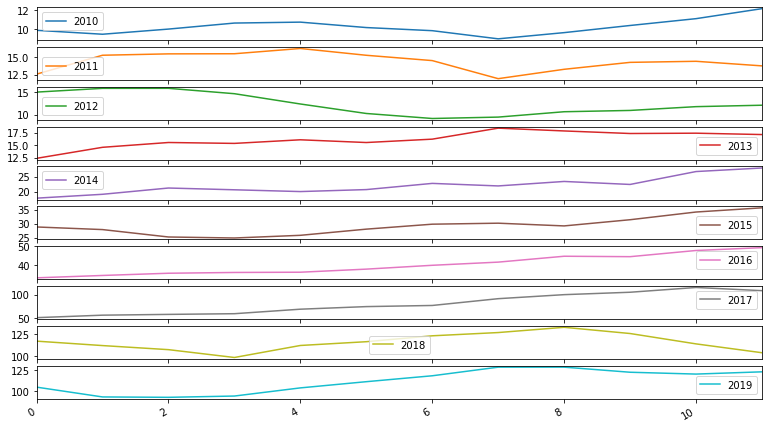

In [9]:
# Create a new DataFrame and store yearly values in columns 
TTWO_annual = pd.DataFrame()

# For loop to group each year separately amd adding it to empty dataframe
for yr, group in yearly:
    TTWO_annual[yr.year] = group.values.ravel()
    
# Plot the yearly groups as subplots
TTWO_annual.plot(figsize = (13,8), subplots=True, legend=True);

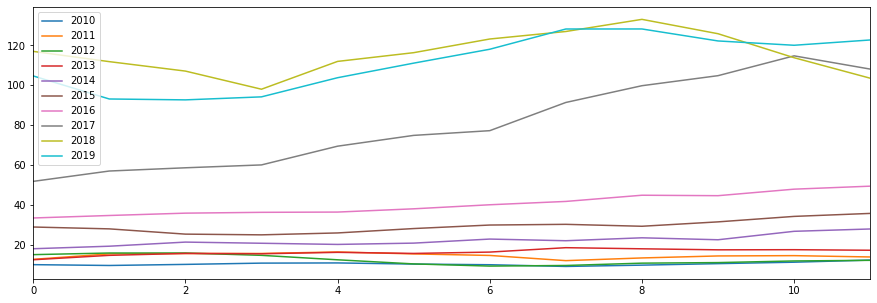

In [10]:
# Plot overlapping yearly groups 
TTWO_annual.plot(figsize = (15,5), subplots=False, legend=True,grid=False);

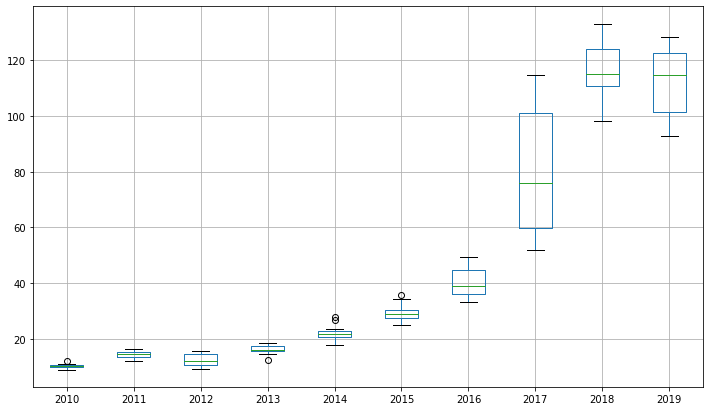

In [11]:
# BoxPlot by year
TTWO_annual.boxplot(figsize = (12,7));

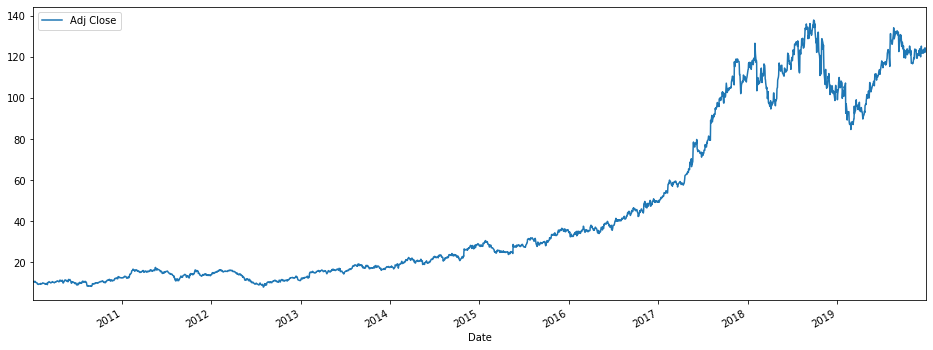

In [12]:
TTWO.plot(figsize = (16,6));

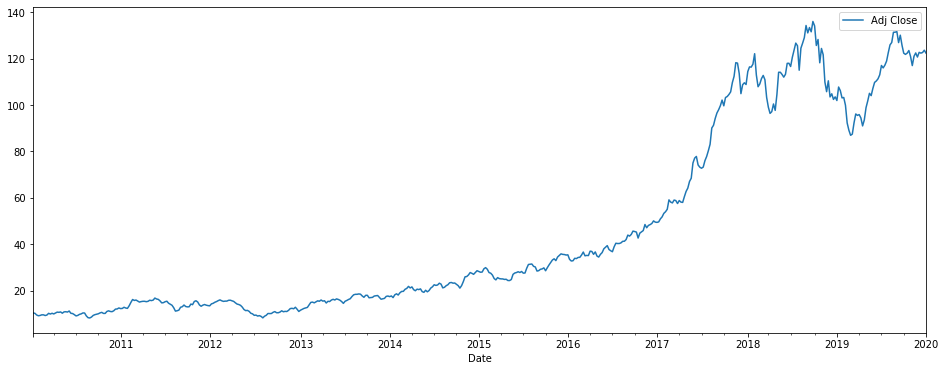

In [13]:
TTWO_weekly.plot(figsize = (16,6));

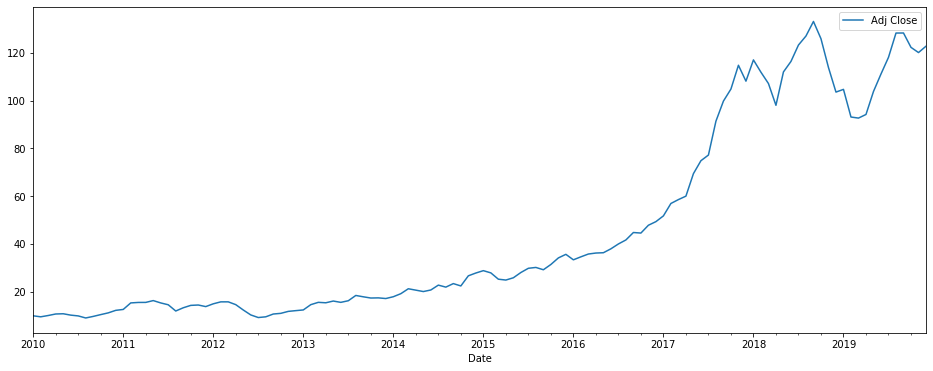

In [14]:
TTWO_monthly.plot(figsize = (16,6));

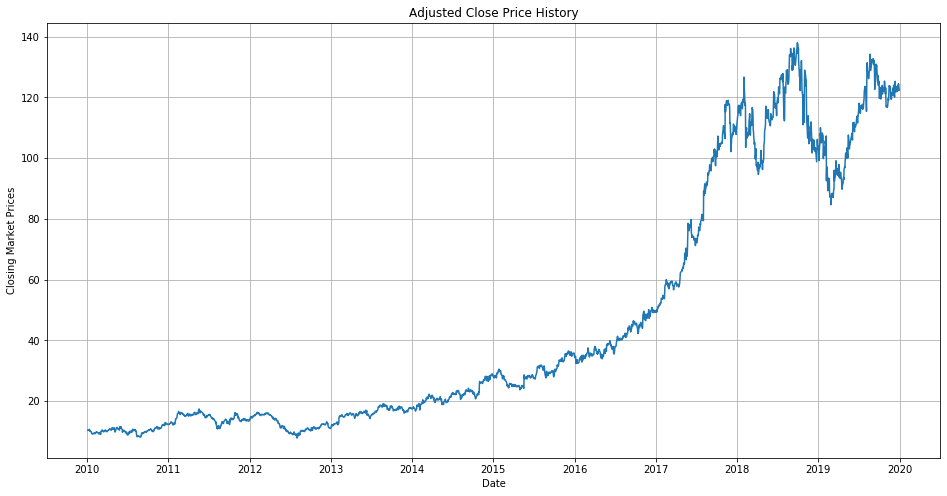

In [15]:
# Plot of Adjusted Close Price history
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Closing Market Prices')
plt.title('Adjusted Close Price History')
plt.plot(TTWO['Adj Close'])
plt.show()

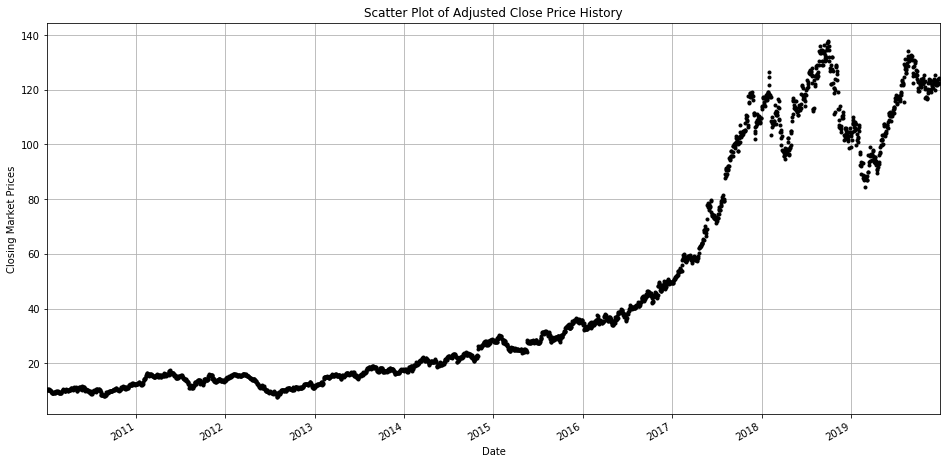

In [16]:
# Scatter Plot of Adjusted Close Price history
plt.figure(figsize=(16,8))
TTWO['Adj Close'].plot(style='k.',)
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Closing Market Prices')
plt.title('Scatter Plot of Adjusted Close Price History')
plt.show() 

In [17]:
# # Filtering DataFrames to only include dates from 2015
# TTWO_filtered = TTWO.loc['2015-01-01':]
# sns.distplot(TTWO_filtered['Adj Close'], hist=True, kde=True,bins=8)

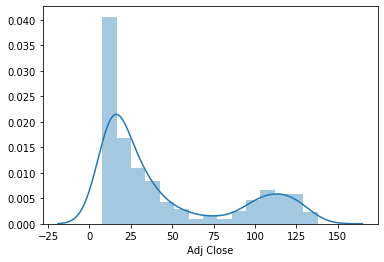

In [18]:
sns.distplot(TTWO['Adj Close'], hist=True, kde=True)

This Density Plot shows the data is not normally distributed. I will need to transform and/or apply differential operations

Null hypothesis: series is stationary


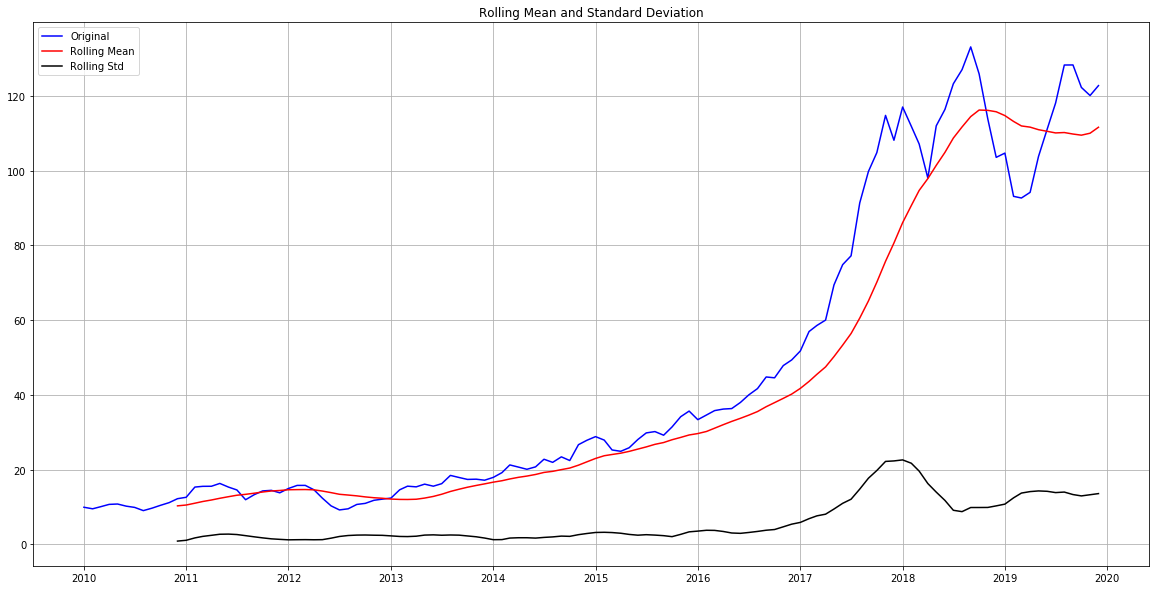

Results of Augmented Dickey Fuller(ADF) Test:
Null Hypothesis: The series has a unit root (value of a =1)
Alternate Hypothesis: The series has no unit root.

Test Statistics                  0.544195
p-value                          0.986156
No. of Lags Used                13.000000
Number of observations used    106.000000
critical value (1%)             -3.493602
critical value (5%)             -2.889217
critical value (10%)            -2.581533
dtype: float64


Results of Kwiatkowski-Phillips-Schmidt-Shin(KPSS) Test:
Null Hypothesis: The process is trend stationary.
Alternate Hypothesis: The series has a unit root (series is not stationary).

Test Statistic            0.81537
p-value                   0.01000
No. of Lags Used         13.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


C:\Users\sdman\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\Users\sdman\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [19]:
# Testing for staionarity

def test_stationarity(timeseries):
    
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    # Plot rolling statistics:
    plt.figure(figsize=(20,10))
    plt.grid(True)
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    # Augmented Dickey Fuller Test (Most commonly used)
    print("Results of Augmented Dickey Fuller(ADF) Test:")
    print('Null Hypothesis: The series has a unit root (value of a =1)\nAlternate Hypothesis: The series has no unit root.\n')
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    # hence we manually write what values does it explains using a for loop
    adft_output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of Lags Used','Number of observations used'])
    for key,values in adft[4].items():
        adft_output['critical value (%s)'%key] =  values
    print(adft_output)
    
    # Kwiatkowski-Phillips-Schmidt-Shin Test (Less commonly used)
    print ('\n\nResults of Kwiatkowski-Phillips-Schmidt-Shin(KPSS) Test:')
    print('Null Hypothesis: The process is trend stationary.\nAlternate Hypothesis: The series has a unit root (series is not stationary).\n')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','No. of Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    
test_stationarity(TTWO_monthly['Adj Close'])

Dick Augmented Dickey Fuller(ADF) Test:

test statistic greater then critical value, which implies that the time series is not stationary

p-value is almost at 1.0 (p-value is greater than 0.05(alpha)) showing again that the time series is not stationary

Kwiatkowski-Phillips-Schmidt-Shin(KPSS) Test:


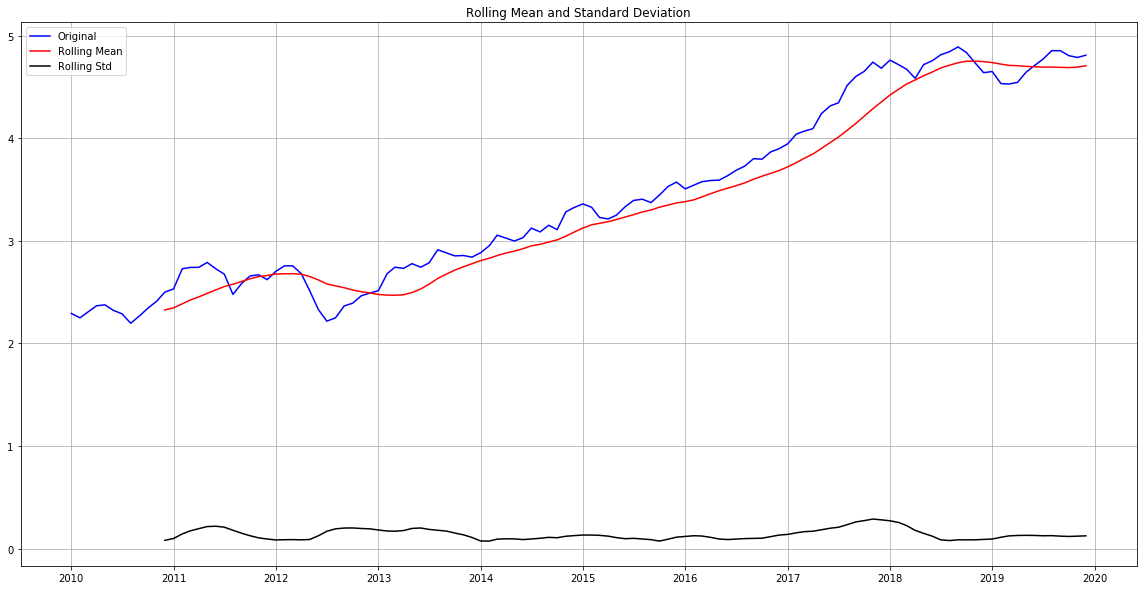

Results of Augmented Dickey Fuller(ADF) Test:
Null Hypothesis: The series has a unit root (value of a =1)
Alternate Hypothesis: The series has no unit root.

Test Statistics                 -0.311485
p-value                          0.923862
No. of Lags Used                 1.000000
Number of observations used    118.000000
critical value (1%)             -3.487022
critical value (5%)             -2.886363
critical value (10%)            -2.580009
dtype: float64


Results of Kwiatkowski-Phillips-Schmidt-Shin(KPSS) Test:
Null Hypothesis: The process is trend stationary.
Alternate Hypothesis: The series has a unit root (series is not stationary).

Test Statistic            0.91795
p-value                   0.01000
No. of Lags Used         13.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


C:\Users\sdman\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [20]:
# Applying Log transformation to the Adj Close values
TTWO_monthly['natural_log'] = TTWO_monthly['Adj Close'].apply(lambda x: np.log(x))  
test_stationarity(TTWO_monthly['natural_log'].dropna(inplace=False))

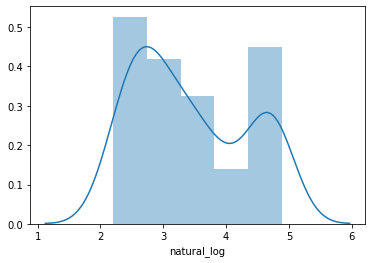

In [21]:
sns.distplot(TTWO_monthly['natural_log'], hist=True, kde=True)

This Density Plot still is not This Density Plot shows a normal distribution.

In [22]:
# First Difference
TTWO_monthly['first_difference'] = TTWO_monthly['Adj Close'] - TTWO_monthly['Adj Close'].shift(1)  

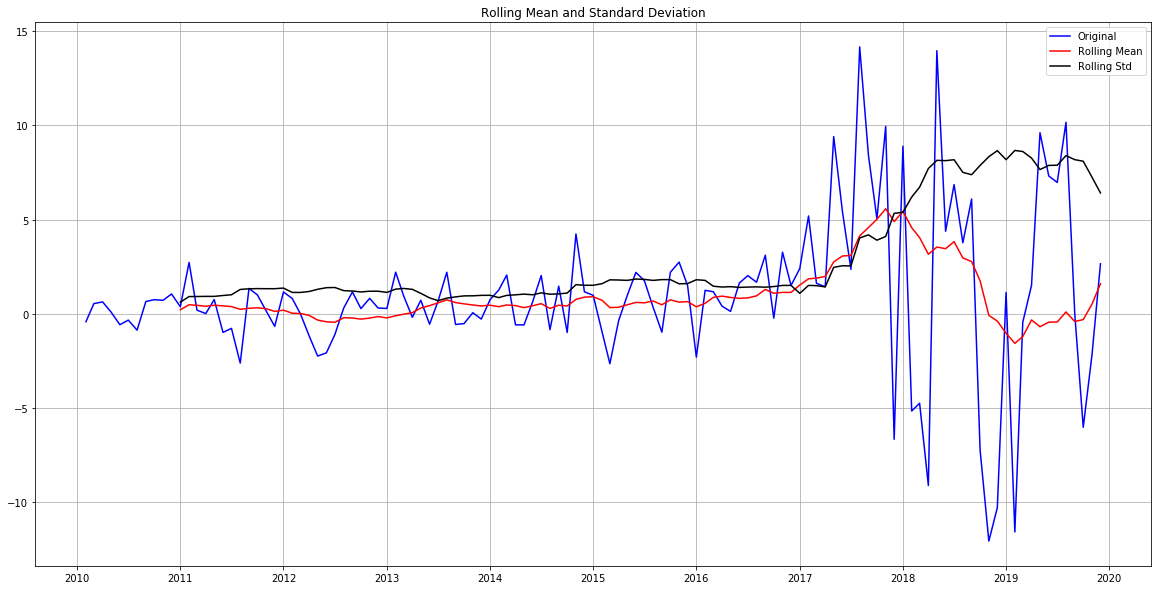

Results of Augmented Dickey Fuller(ADF) Test:
Null Hypothesis: The series has a unit root (value of a =1)
Alternate Hypothesis: The series has no unit root.

Test Statistics                 -2.351184
p-value                          0.155991
No. of Lags Used                12.000000
Number of observations used    106.000000
critical value (1%)             -3.493602
critical value (5%)             -2.889217
critical value (10%)            -2.581533
dtype: float64


Results of Kwiatkowski-Phillips-Schmidt-Shin(KPSS) Test:
Null Hypothesis: The process is trend stationary.
Alternate Hypothesis: The series has a unit root (series is not stationary).

Test Statistic            0.251038
p-value                   0.100000
No. of Lags Used         13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\sdman\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [23]:
# First Difference
TTWO_monthly['first_difference'] = TTWO_monthly['Adj Close'] - TTWO_monthly['Adj Close'].shift(1)  
test_stationarity(TTWO_monthly['first_difference'].dropna(inplace=False))

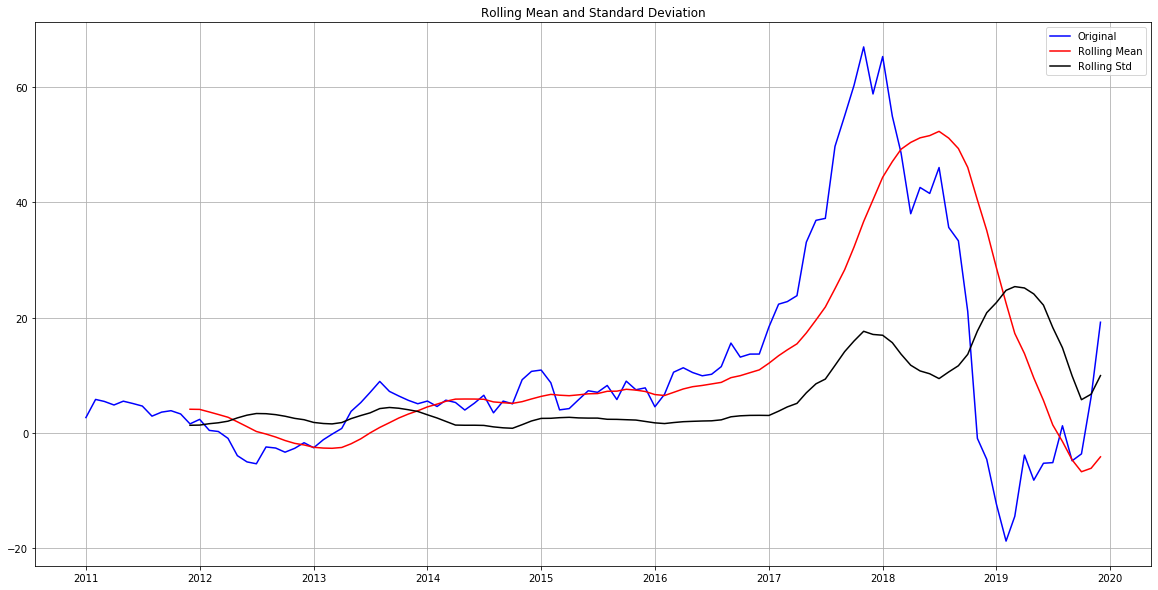

Results of Augmented Dickey Fuller(ADF) Test:
Null Hypothesis: The series has a unit root (value of a =1)
Alternate Hypothesis: The series has no unit root.

Test Statistics                -1.525511
p-value                         0.520856
No. of Lags Used               13.000000
Number of observations used    94.000000
critical value (1%)            -3.501912
critical value (5%)            -2.892815
critical value (10%)           -2.583454
dtype: float64


Results of Kwiatkowski-Phillips-Schmidt-Shin(KPSS) Test:
Null Hypothesis: The process is trend stationary.
Alternate Hypothesis: The series has a unit root (series is not stationary).

Test Statistic            0.274662
p-value                   0.100000
No. of Lags Used         13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\sdman\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [24]:
# Seasonal Difference
TTWO_monthly['seasonal_difference'] = TTWO_monthly['Adj Close'] - TTWO_monthly['Adj Close'].shift(12)
test_stationarity(TTWO_monthly['seasonal_difference'].dropna(inplace=False))

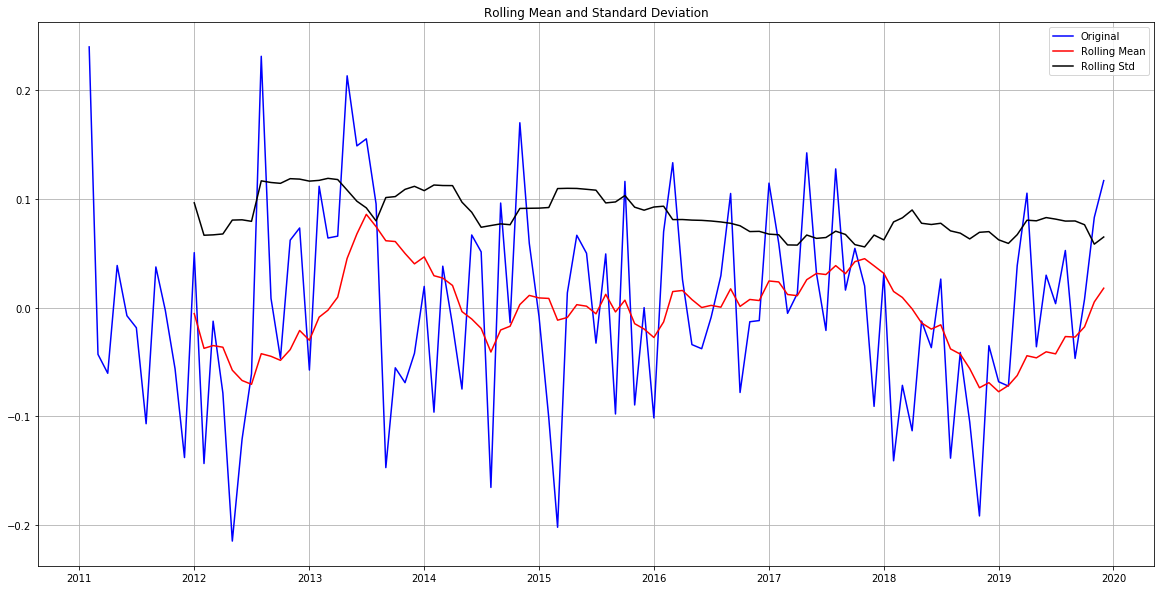

Results of Augmented Dickey Fuller(ADF) Test:
Null Hypothesis: The series has a unit root (value of a =1)
Alternate Hypothesis: The series has no unit root.

Test Statistics                -3.990280
p-value                         0.001462
No. of Lags Used               11.000000
Number of observations used    95.000000
critical value (1%)            -3.501137
critical value (5%)            -2.892480
critical value (10%)           -2.583275
dtype: float64


Results of Kwiatkowski-Phillips-Schmidt-Shin(KPSS) Test:
Null Hypothesis: The process is trend stationary.
Alternate Hypothesis: The series has a unit root (series is not stationary).

Test Statistic            0.057701
p-value                   0.100000
No. of Lags Used         13.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\sdman\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [25]:
# Seasonal Difference of the log first difference (shifting only 1)
TTWO_monthly['log_first_difference'] = TTWO_monthly.natural_log - TTWO_monthly.natural_log.shift(1)  
TTWO_monthly['log_seasonal_first_difference'] = TTWO_monthly.log_first_difference - TTWO_monthly.log_first_difference.shift(12)  

test_stationarity(TTWO_monthly.log_seasonal_first_difference.dropna(inplace=False))

Dick Augmented Dickey Fuller(ADF) Test:

test statistic less then critical value, which implies that the time series is finally stationary

p-value is Less than 0.05 (the accepted alpha value)

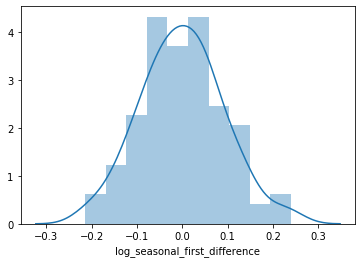

In [26]:
sns.distplot(TTWO_monthly['log_seasonal_first_difference'].dropna(inplace=False), hist=True, kde=True)

This Density Plot is shows a normal distribution.

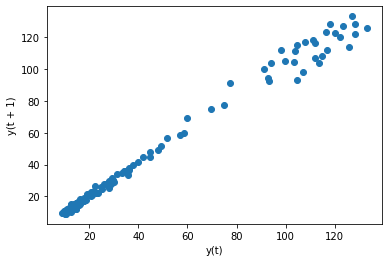

In [27]:
lag_plot(TTWO_monthly['Adj Close']);

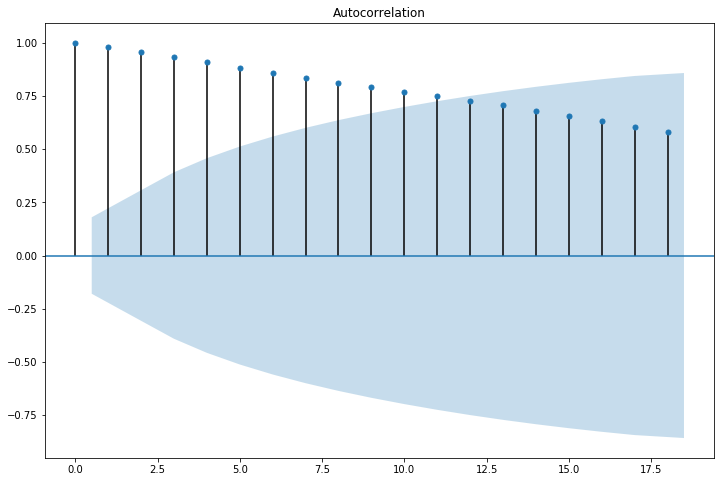

In [28]:
#ACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
#plot the ACF
fig = sm.graphics.tsa.plot_acf(TTWO_monthly['natural_log'].iloc[1:], lags=18, ax=ax1)

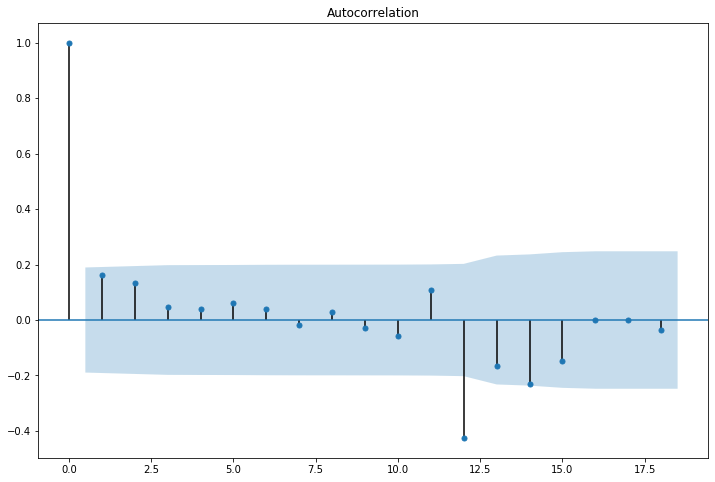

In [29]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
#plot the ACF
fig = sm.graphics.tsa.plot_acf(TTWO_monthly['log_seasonal_first_difference'].iloc[13:], lags=18, ax=ax1)

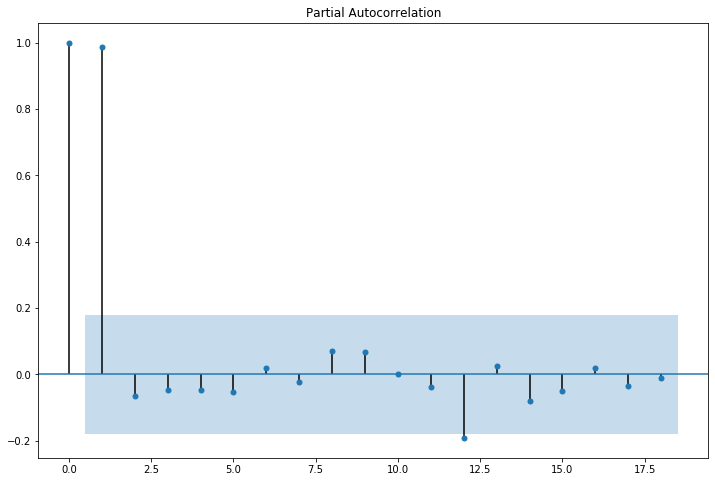

In [30]:
# Partial Correlation
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(TTWO_monthly['natural_log'].iloc[1:], lags=18, ax=ax1)

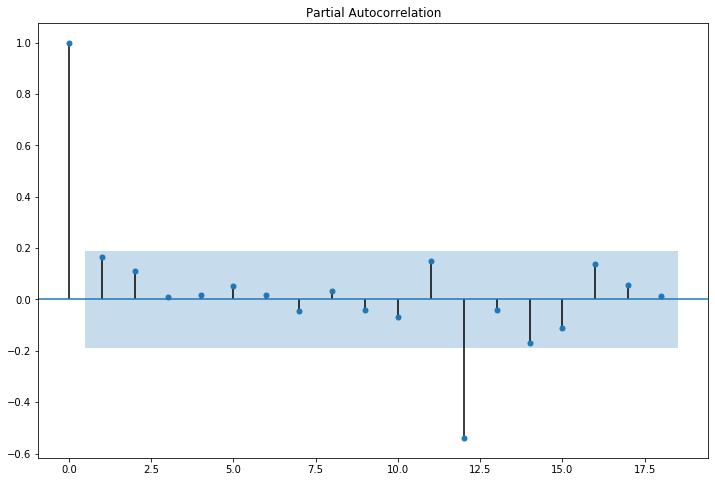

In [31]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot()
#plot the ACF
fig = sm.graphics.tsa.plot_pacf(TTWO_monthly['log_seasonal_first_difference'].iloc[13:], lags=18, ax=ax1)

C:\Users\sdman\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  


<Figure size 432x288 with 0 Axes>

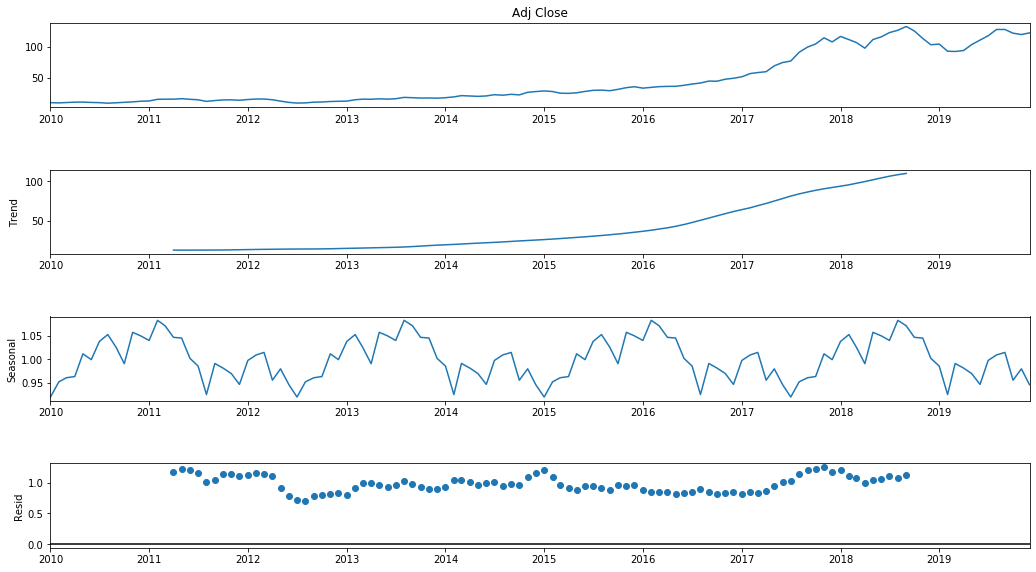

In [32]:
# Decomposition - Separating seasonality and trend from the model
result = seasonal_decompose(TTWO_monthly['Adj Close'].dropna(inplace=False), model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

C:\Users\sdman\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  


<Figure size 432x288 with 0 Axes>

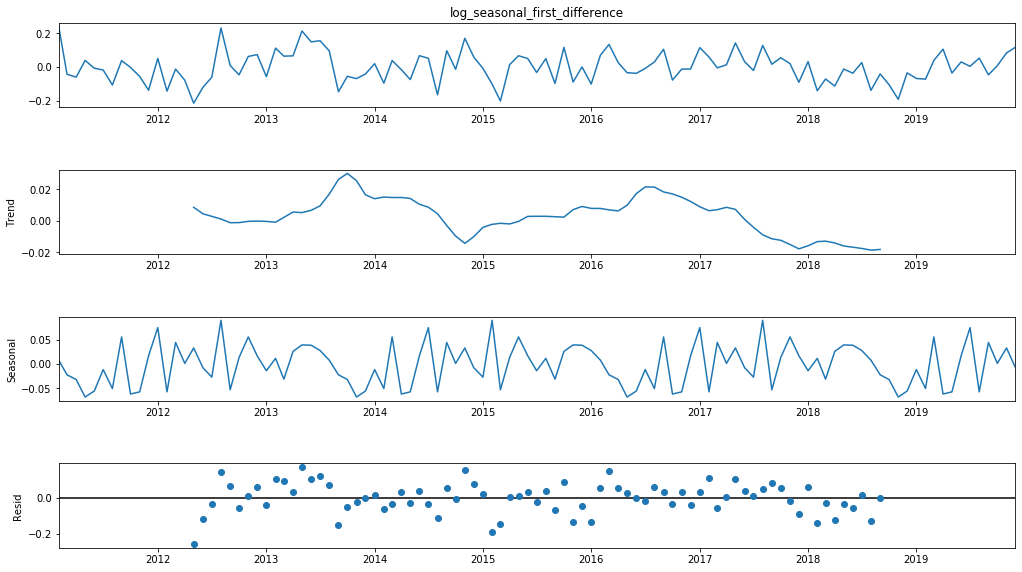

In [33]:
# Decomposition - Separating seasonality and trend from the model
result = seasonal_decompose(TTWO_monthly['log_seasonal_first_difference'].dropna(inplace=False), model='additive', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

The trend is showing a Exponential upward trend (generally)


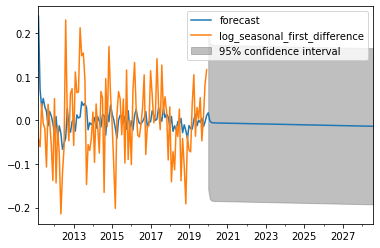

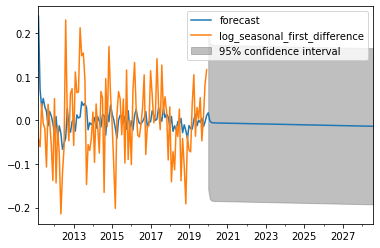

In [34]:
model = ARIMA(TTWO_monthly['log_seasonal_first_difference'].dropna(inplace=False), order=(1, 1, 1))
results = model.fit()
results.plot_predict(1, 210)

In [71]:
# Function to preform Auto ARIMA on timeseries
def arimamodel(timeseries):
    automodel = pm.auto_arima(timeseries, 
                              start_p=1, 
                              start_q=1,
                              test="adf",
                              seasonal=False,
                              trace=True)
    return automodel


# Function to plot predicted values from arima and validation data
def plotarima(timeseries, automodel,valid_data,forecast_multiplier):
    # Forecast
    fc, confint = automodel.predict(len(valid_data)*forecast_multiplier, 
                                    return_conf_int=True)
    # Weekly index
    fc_ind = pd.date_range(timeseries.index[timeseries.shape[0]-1], 
                           periods=len(valid_data)*forecast_multiplier, freq="W")
    # Forecast series
    fc_series = pd.Series(fc, index=fc_ind)
    # Upper and lower confidence bounds
    lower_series = pd.Series(confint[:, 0], index=fc_ind)
    upper_series = pd.Series(confint[:, 1], index=fc_ind)
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.grid(True)
    plt.plot(timeseries)
    plt.plot(fc_series, color="red")
    plt.xlabel("date")
    plt.ylabel(str(timeseries))
    plt.fill_between(lower_series.index, 
                     lower_series, 
                     upper_series, 
                     color="k", 
                     alpha=0.05)
    plt.legend(("past", "forecast", "95% confidence interval"),  
               loc="upper left")
    # Plot Validation data to check prediction
    plt.plot(valid_data,color='green',label='Valid')
    plt.show()
    # Show SARIMAX Results
    automodel.summary()
    # Root Mean Squared Error
    rmse = sqrt(mean_squared_error(valid_data,fc_series[:len(valid_data)]))
    print(f"Model's Root Mean Squared Error: {rmse}")

Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=667.483, BIC=678.599, Time=0.055 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=675.605, BIC=681.163, Time=0.009 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=667.628, BIC=675.965, Time=0.031 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=670.884, BIC=679.222, Time=0.047 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=679.905, BIC=682.684, Time=0.009 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=662.015, BIC=675.911, Time=0.086 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=665.062, BIC=676.179, Time=0.048 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=663.985, BIC=680.659, Time=0.170 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=663.984, BIC=680.658, Time=0.134 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=666.588, BIC=680.484, Time=0.115 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=665.379

C:\Users\sdman\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\sdman\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=665.212, BIC=684.666, Time=0.216 seconds
Total fit time: 1.008 seconds


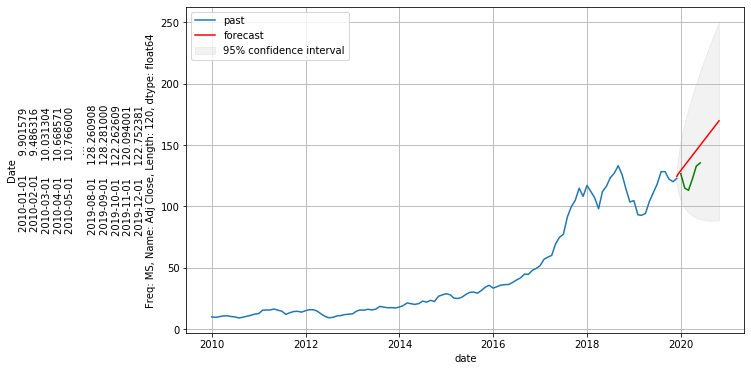

Model's Root Mean Squared Error: 8.044125908266675


In [72]:
automodel = arimamodel(TTWO_monthly['Adj Close'].dropna(inplace=False))
plotarima(TTWO_monthly['Adj Close'], automodel,valid_monthly,8)


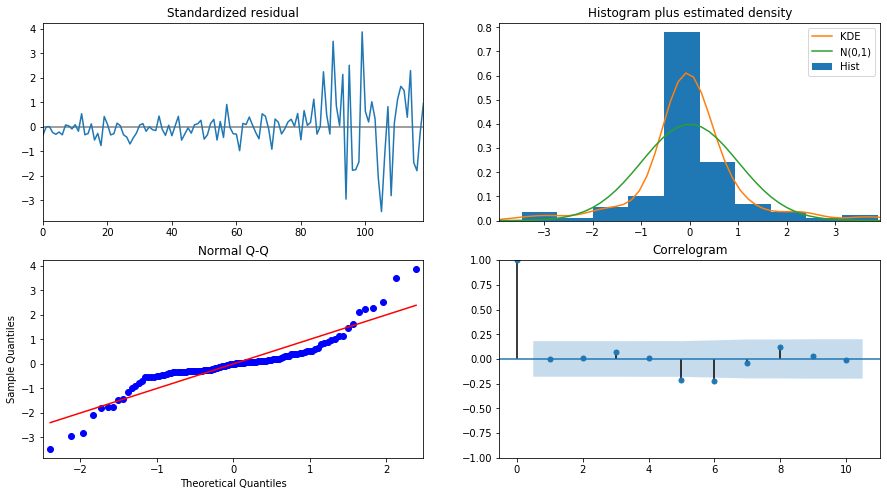

In [67]:
automodel.plot_diagnostics(figsize=(15,8))
plt.show()

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=663.984, BIC=680.658, Time=0.149 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=675.605, BIC=681.163, Time=0.009 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=667.628, BIC=675.965, Time=0.030 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=670.884, BIC=679.222, Time=0.051 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=679.905, BIC=682.684, Time=0.009 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=666.588, BIC=680.484, Time=0.114 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=662.015, BIC=675.911, Time=0.098 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=667.483, BIC=678.599, Time=0.055 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=665.062, BIC=676.179, Time=0.051 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=663.985, BIC=680.659, Time=0.180 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=665.379

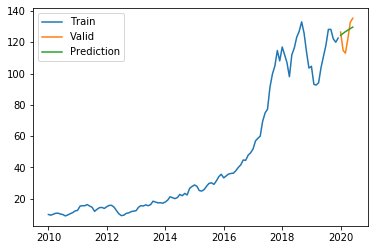

In [68]:
model = auto_arima(TTWO_monthly['Adj Close'], trace=True, error_action='ignore', suppress_warnings=True,)
automodel.fit(TTWO_monthly['Adj Close'])

forecast = automodel.predict(n_periods=len(valid_monthly))
forecast = pd.DataFrame(forecast,index = valid_monthly.index,columns=['Prediction'])

plt.plot(TTWO_monthly['Adj Close'].dropna(inplace=False), label='Train')
plt.plot(valid_monthly, label='Valid')
plt.plot(forecast, label='Prediction')
plt.legend()
plt.show()

In [40]:
# Root Mean Squared Error
rmse = sqrt(mean_squared_error(valid_monthly,forecast))
print(rmse)

8.044125908266675


Performing stepwise search to minimize aic
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=8624.813, BIC=8648.133, Time=0.802 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=8652.887, BIC=8664.547, Time=0.059 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=8639.249, BIC=8656.739, Time=0.183 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=8636.138, BIC=8653.628, Time=0.310 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=8653.622, BIC=8659.452, Time=0.049 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=8612.517, BIC=8641.667, Time=0.945 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=8619.418, BIC=8642.738, Time=0.265 seconds
Fit ARIMA(3,1,1)x(0,0,0,0) [intercept=True]; AIC=8610.932, BIC=8645.912, Time=0.864 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=8609.904, BIC=8639.054, Time=0.312 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=8607.809, BIC=8642.789, Time=0.481 seconds
Fit ARIMA(5,1,0)x(0,0,0,0) [intercep

C:\Users\sdman\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\sdman\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


Fit ARIMA(4,1,2)x(0,0,0,0) [intercept=True]; AIC=8581.819, BIC=8628.459, Time=3.283 seconds
Total fit time: 17.308 seconds


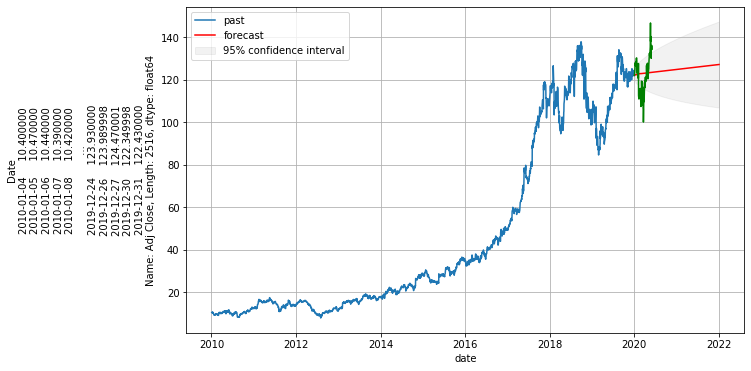

Model's Root Mean Squared Error: 8.850075379752774


In [74]:
automodel = arimamodel(TTWO['Adj Close'].dropna(inplace=False))
plotarima( TTWO['Adj Close'], automodel,valid,1)
